**Import Libraries and Define constants**

In [1]:
#### Training based on features of audio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sknn.mlp import Classifier, Layer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier





/home/vuthede/.local/lib64/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load data**

Size input, output: 10018 ,  10018
[1.5 4.  4.  ... 1.5 2.  2.5]
Distinct output:  {0.5, 1.5, 2.5, 3.5, 3.0, 4.0, 2.0, 4.5, 5.0, 1.0, 2.3333, 2.6667, 4.3333, 2.25, 2.75, 3.25, 3.75, 4.75, 4.25, 5.5, 1.3333, 3.3333, 4.6667, 1.6667, 3.6667}
Average labels: 2.7782824016769814
Std labels: 0.8970523348000802


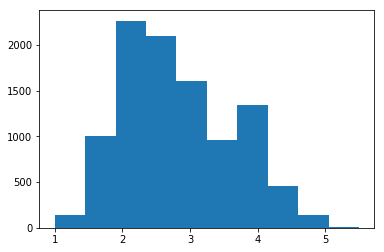

In [2]:

##Loading  data from files
filehandlerInput = open('processed-data/input_VAD.obj', 'rb')
filehandlerOutput = open('processed-data/output_VAD.obj', 'rb')
input = pickle.load(filehandlerInput)
output = pickle.load(filehandlerOutput)
print("Size input, output:", len(input),", ", len(output))
flattened_out = output.flatten()
print(flattened_out)
print("Distinct output: ", set(flattened_out))

import matplotlib.pyplot as plt
import numpy as np

print("Average labels:", np.average(output[:,0]))
print("Std labels:", np.std(output[:,0]))
plt.hist(output[:,0])
plt.show()



**Preprocess data**

In [3]:
from keras.utils.np_utils import to_categorical

input_filtered = input[~np.any(np.isnan(input), axis=1)]
output_filtered = output[~np.any(np.isnan(input), axis=1)]
print("Size input, output after remove Nan values ", len(input_filtered), ", ", len(output_filtered))

#Normalize input
input_filtered = (input_filtered - input_filtered.min(axis=0)) / (input_filtered.max(axis=0) - input_filtered.min(axis=0))

#Normalize output
#output_filtered = [to_categorical(out, 6) for out in output_filtered]
output_filtered = (output_filtered - output_filtered.min(axis=0)) / (output_filtered.max(axis=0) - output_filtered.min(axis=0))
print("Normalize input and categorize output ")
print(len(output_filtered))



/usr/lib64/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Size input, output after remove Nan values  10009 ,  10009
Normalize input and categorize output 
10009


**Shuffer data**

In [4]:
#Shuffer
c = list(zip(input_filtered, output_filtered))
random.shuffle(c)
input_filtered, output_filtered = zip( * c)
input_filtered = np.array(input_filtered)
output_filtered = np.array(output_filtered)
print(output_filtered)

[[0.33333333 0.5        0.44444444]
 [0.44444444 0.5        0.55555556]
 [0.66666667 0.375      0.55555556]
 ...
 [0.33333333 0.375      0.66666667]
 [0.55555556 0.625      0.66666667]
 [0.66666667 0.625      0.77777778]]


**Split data**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(input_filtered, output_filtered, test_size=0.1, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))

print(output_filtered[:,1])


Size training, testing set:  9008 ,  1001
[0.5   0.5   0.375 ... 0.375 0.625 0.625]


**Training on keras**

In [6]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation



model = Sequential([
    Dense(64, input_shape=(88,), kernel_initializer='normal'),
    Activation('relu'),
    Dense(32, kernel_initializer='normal'),
    Activation('relu'),
    Dense(16,kernel_initializer='normal'),
    Activation('relu'),
    Dense(8, kernel_initializer='normal'),
    Activation('relu'),
    Dense(1),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train[:,0], validation_data=(X_test, y_test[:,0]), epochs = 10)
#model.fit(X_train[0:2], y_train[0:2,0], validation_data=(X_test[0:2], y_test[0:2,0]), epochs = 1000)

model1 = Sequential([
    Dense(64, input_shape=(88,), kernel_initializer='normal'),
    Activation('relu'),
    Dense(32, kernel_initializer='normal'),
    Activation('relu'),
    Dense(16,kernel_initializer='normal'),
    Activation('relu'),
    Dense(8, kernel_initializer='normal'),
    Activation('relu'),
    Dense(1),
])
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(X_train, y_train[:,1], validation_data=(X_test, y_test[:,1]), epochs = 10)


model2 = Sequential([
    Dense(64, input_shape=(88,), kernel_initializer='normal'),
    Activation('relu'),
    Dense(32, kernel_initializer='normal'),
    Activation('relu'),
    Dense(16,kernel_initializer='normal'),
    Activation('relu'),
    Dense(8, kernel_initializer='normal'),
    Activation('relu'),
    Dense(1),
])
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(X_train, y_train[:,2], validation_data=(X_test, y_test[:,2]), epochs = 10)



Train on 9008 samples, validate on 1001 samples
Epoch 1/10
9008/9008 [==============================] - 2s 274us/step - loss: 0.0512 - val_loss: 0.0386
Epoch 2/10
9008/9008 [==============================] - 1s 71us/step - loss: 0.0381 - val_loss: 0.0379
Epoch 3/10
9008/9008 [==============================] - 1s 72us/step - loss: 0.0366 - val_loss: 0.0399
Epoch 4/10
9008/9008 [==============================] - 1s 71us/step - loss: 0.0358 - val_loss: 0.0364
Epoch 5/10
9008/9008 [==============================] - 1s 70us/step - loss: 0.0351 - val_loss: 0.0347
Epoch 6/10
9008/9008 [==============================] - 1s 70us/step - loss: 0.0347 - val_loss: 0.0351
Epoch 7/10
9008/9008 [==============================] - 1s 69us/step - loss: 0.0343 - val_loss: 0.0342
Epoch 8/10
9008/9008 [==============================] - 1s 69us/step - loss: 0.0343 - val_loss: 0.0356
Epoch 9/10
9008/9008 [==============================] - 1s 70us/step - loss: 0.0344 - val_loss: 0.0362
Epoch 10/10
9008/9008 [=

**Coefficient of Determination**

In [7]:
from sklearn.metrics import r2_score

predict = model.predict(X_test)
predict1 = model1.predict(X_test)
predict2 = model2.predict(X_test)

a = r2_score(y_test[:,0], predict)
print("The R2 for Valance: " ,a)

a1 = r2_score(y_test[:,1], predict1)
print("The R2 for Activation: " ,a1)

a2 = r2_score(y_test[:,2], predict2)
print("The R2 for Dominance: " ,a2)


The R2 for Valance:  0.05477503945485129
The R2 for Activation:  0.4669469723663988
The R2 for Dominance:  0.3075291661909145


If the Coefficient of Determination is **low**, It means the model work badly and does not fit the test data

**Distribution of err**

1001
[405483 318494 180467  70476  23857   3034    189      1      0]


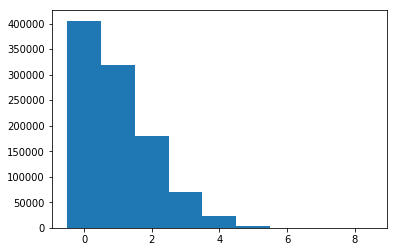

In [8]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 10)
data = np.abs(predict - y_test[:,1])
print(len(data))
hist, bin_edges = np.histogram(data,bins) # make the histogram
print(hist)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# # Set the ticks to the middle of the bars
# ax.set_xticks([0.5+i for i,j in enumerate(hist)])

# # # Set the xticklabels to a string that tells us what the bin edges were
# # ax.set_xticklabels(['{} - {}'.format(bins[i],bins[i+1]) for i,j in enumerate(hist)])

plt.show()


#predict = model.predict(X_test)

#plt.hist(subs, bins =bins)

**Standard residual plot**

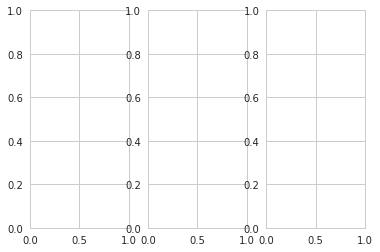

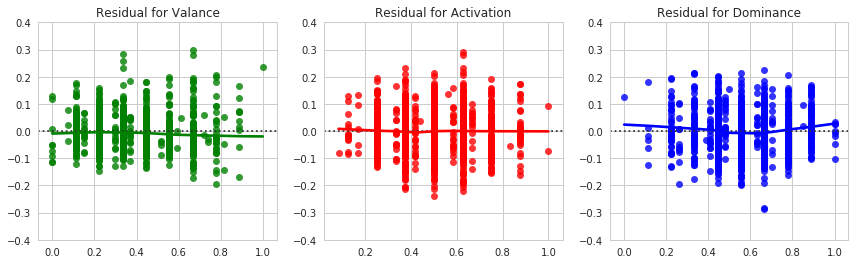

In [10]:
import seaborn as sns
from matplotlib.pyplot import subplots_adjust
sns.set(style="whitegrid")

fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
predict = model.predict(X_test)
predict = np.array([p[0] for p in predict])
axs[0] = sns.residplot(y_test[:,0], predict, lowess=True, color="g", ax=axs[0])
axs[0].set_ylim([-0.4,0.4])
axs[0].set_title("Residual for Valance") 


predict1 = model1.predict(X_test)
predict1 = np.array([p[0] for p in predict1])
axs[1] = sns.residplot(y_test[:,1], predict1, lowess=True, color="r", ax=axs[1])
axs[1].set_ylim([-0.4,0.4])
axs[1].set_title("Residual for Activation")

predict2 = model2.predict(X_test)
predict2 = np.array([p[0] for p in predict2])
axs[2] = sns.residplot(y_test[:,2], predict2, lowess=True, color="b", ax=axs[2])
axs[2].set_ylim([-0.4,0.4])
axs[2].set_title("Residual for Dominance")


plt.show()
plt.close()


The residual plot show that the error followed random pattern. If the residual plot is not enough random, then the model would be likely to lose something. 

**Playing around with prediction**

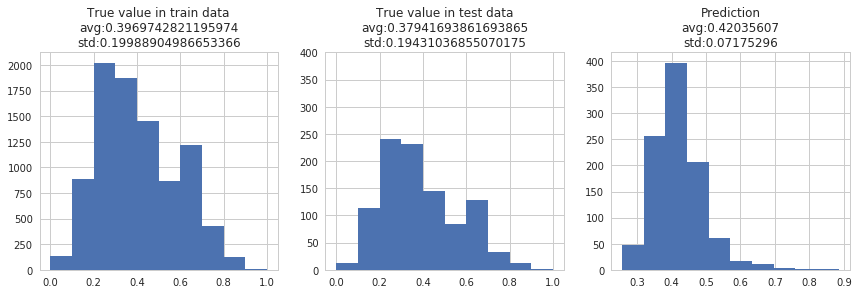

In [13]:

predict = model.predict(X_test)
#print(predict)

subs = np.abs(predict - y_test[:,0])


fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
axs[0].hist(y_train[:,0])
axs[0].set_title("True value in train data\n" + 
                 "avg:" + str(np.average(y_train[:,0])) + 
                 "\nstd:" + str(np.std(y_train[:,0])))
axs[1].hist(y_test[:,0])
axs[1].set_title("True value in test data\n" + 
                 "avg:" + str(np.average(y_test[:,0])) + 
                 "\nstd:" + str(np.std(y_test[:,0])))
axs[1].set_ylim([0,400])
                        
axs[2].hist(predict) 
axs[2].set_title("Prediction\n" +
                "avg:" + str(np.average(predict)) + 
                 "\nstd:" + str(np.std(predict)))
                
# axs[2].hist(subs, bins='auto')
# axs[2].set_title("error on predictions")

plt.show()
plt.close()


In [35]:
predict = model.predict(X_test)
bins = np.linspace(0, 1, 11)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)

for r in bin_ranges:
    # Get valance
    y = y_test[:,0]
    condition = [r[0] <= e <= r[1]for e in y]
    y = y[condition]
    pre = predict[condition]
    subs = np.abs(y-pre)
    print("Avg, std in range " , )

    